In [ ]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import TfidfModel, LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.similarities import SparseMatrixSimilarity
from gensim import corpora, models, similarities
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('cleaned_products.csv')
df.head()

,product_id,product_name,category,sub_category,price,link,image,rating,final_cleaned_tokens
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,86250.0,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,4.9,"['áo', 'lỗ', 'thun', 'gân', 'form', 'body', 't..."
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,26800.0,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,4.9,"['áo', 'lỗ', 'nam', 'trắng', 'chất cotton', 's..."
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,39500.0,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,4.8,"['áo', 'lỗ', 'nam', 'tyasuo', 'chất', 'vải', '..."
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,16500.0,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,4.8,"['áo', 'lỗ', 'hàng', 'việt nam', '100', 'cotto..."
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,45000.0,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,4.8,"['áo', 'thun', 'nam', 'thể thao', 'lỗ', 'mẫu',..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48700 entries, 0 to 48699
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            48700 non-null  int64  
 1   product_name          48700 non-null  object 
 2   category              48700 non-null  object 
 3   sub_category          48700 non-null  object 
 4   price                 48700 non-null  float64
 5   link                  48700 non-null  object 
 6   image                 35542 non-null  object 
 7   rating                48700 non-null  float64
 8   final_cleaned_tokens  48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.3+ MB


In [ ]:
df['final_cleaned_tokens'] = df['final_cleaned_tokens'].apply(ast.literal_eval)
df['final_cleaned_tokens'].head()


0    [áo, lỗ, thun, gân, form, body, tôn dáng, áo, ...
1    [áo, lỗ, nam, trắng, chất cotton, siêu mát, si...
2    [áo, lỗ, nam, tyasuo, chất, vải, co dãn, mát, ...
3    [áo, lỗ, hàng, việt nam, 100, cotton, áo, lỗ, ...
4    [áo, thun, nam, thể thao, lỗ, mẫu, siêu đẹp, b...
Name: final_cleaned_tokens, dtype: object

/home/linh/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/linh/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/linh/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


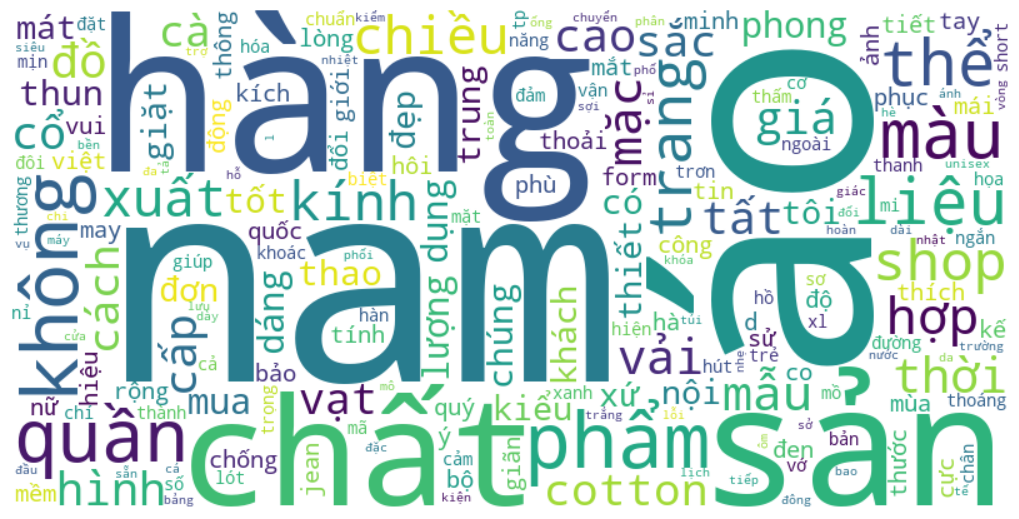

In [ ]:
text = ' '.join([' '.join(tokens) for tokens in df['final_cleaned_tokens']])

# Tạo Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False,
    font_path=None  # Nếu cần hỗ trợ tiếng Việt đẹp hơn
).generate(text)

# Hiển thị Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### 1. Làm sạch bổ sung token (Loại số và ký tự đặc biệt dư thừa)

In [ ]:
sample_df = df.sample(10000, random_state=42).reset_index(drop=True)

In [ ]:
# Load stopwords
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = set(f.read().splitlines())

# Làm sạch từng token trong list
content_gem_re = [
    [
        re.sub(r'[0-9]+', '', token.lower())
        for token in tokens
        if token.lower() not in stop_words and token not in ['', ' ', ',', '.', '...', '-', ':', ';', '?', '%', '(', ')', '+', '/', "'", '&']
    ]
    for tokens in sample_df['final_cleaned_tokens']
]
# Kiểm tra
print(len(content_gem_re))
print(content_gem_re[:1])

10000
[['kính', 'mát nam', 'lacoste', 'cao cấp', 'chống', 'tia', 'uv', 'kính', 'mắt', 'nam kính', 'mát', 'tình trạng', 'sử dụng', 'thương hiệu', 'lacoste', 'xuất xứ', 'lens', 'chống', 'tia', 'uv', 'chất liệu', 'khung', 'kính', 'thép', 'không', 'gỉ', 'hình dạng', 'khung', 'kính', 'tròn', 'kính', 'rim', 'giới tính', 'nam', 'chất liệu', 'titan', '', 'vĩnh phúc', 'kính', 'mắt', 'nam nữ', 'cao cấp', 'siêu bền', 'mắt kính', 'thời trang', 'phon', 'thời trang', 'đặc điểm', 'nổi trội', 'kính', 'mắt', 'thời trang', 'kiểu dáng', 'sang trọng', 'trẻ trung bắt', 'mắt', 'làm quà', 'tặng', 'kính', 'nguyên bộ', 'hộp', 'hãng', 'gộp', 'giấy', 'fullbox khăn', 'lau mềm', 'cao cấp', 'sử dụng', 'mô tả', 'sản phẩm', 'chất liệu', 'gọng', 'nhựa', 'cao cấp', 'dòng', 'hoàn hảo', 'chất liệu', 'thiết kế', 'sản phẩm', 'ốc', 'vít', 'chốt', 'khóa', 'kim loại', 'chống', 'gỉ', 'bền bỉ', 'sang trọng', 'chất liệu', 'tròng', 'kính', 'tròng', 'polycabonat', 'hỗn hợp', 'thủy tinh', 'nhựa', 'cao cấp', 'chống', 'vỡ', 'hạn chế'

### 2. Tạo Model với Gensim

In [ ]:
# Tạo dictionary
dictionary = corpora.Dictionary(content_gem_re)

# Số lượng feature
print(f'Total features: {len(dictionary.token2id)}')

# Tạo corpus: dạng (token_id, frequency)
corpus = [dictionary.doc2bow(text) for text in content_gem_re]

# Kiểm tra sample corpus
print(corpus[0])

Total features: 37248
[(0, 2), (1, 1), (2, 5), (3, 5), (4, 5), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 9), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 4), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 3), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 2), (57, 1), (58, 1), (59, 1), (60, 5), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1)]


In [ ]:
# Tạo mô hình TF-IDF
tfidf = models.TfidfModel(corpus)

# Tính similarity dùng SparseMatrixSimilarity
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.token2id))

# Kiểm tra index
print(index)

In [ ]:
kw_vector = dictionary.doc2bow(content_gem_re[0])
similarities_index = index[tfidf[kw_vector]]

similarities_sorted = np.argsort(-similarities_index)
print(f'Các sản phẩm tương tự sản phẩm đầu tiên: {similarities_sorted[:5]}')


Các sản phẩm tương tự sản phẩm đầu tiên: [   0 9085 6067 2369 3328]


#### Recommend sản phẩm

In [ ]:
def recommend_similar_products_gensim(product_id, sample_df, index, dictionary, tfidf, content_gem_re, top_n=10):
    try:
        product_idx = sample_df.index[sample_df['product_id'] == product_id][0]
    except IndexError:
        raise ValueError(f'Product ID {product_id} not found in the sample DataFrame.')

    query_doc = content_gem_re[product_idx]
    query_bow = dictionary.doc2bow(query_doc)
    query_tfidf = tfidf[query_bow]
    sims = index[query_tfidf]

    sim_scores = sorted(enumerate(sims), key=lambda x: x[1], reverse=True)
    top_indices = [score[0] for score in sim_scores if score[0] != product_idx][:top_n]

    return sample_df.iloc[top_indices]['product_id'].tolist()


### 3. Tạo model với Cosine

In [ ]:
# Chuyển tokens về text cho vectorizer
documents = [' '.join(tokens) for tokens in content_gem_re]
# Vector hóa TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
print(tfidf_matrix.shape)  # Kiểm tra shape của ma trận


(10000, 17884)


In [ ]:
# Tính cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Xem ma trận
cosine_sim_df = pd.DataFrame(cosine_sim, index=sample_df['product_id'], columns=sample_df['product_id'])
print(cosine_sim_df.head())


product_id    121842    1412      173071    17926     151494    201030  \
product_id                                                               
121842      1.000000  0.110975  0.005613  0.116686  0.037837  0.059950   
1412        0.110975  1.000000  0.036132  0.137271  0.190578  0.177386   
173071      0.005613  0.036132  1.000000  0.225428  0.033213  0.096559   
17926       0.116686  0.137271  0.225428  1.000000  0.108176  0.079801   
151494      0.037837  0.190578  0.033213  0.108176  1.000000  0.095888   

product_id    173309    221053    221001    211527  ...    19926     10497   \
product_id                                          ...                       
121842      0.102358  0.044509  0.165649  0.080320  ...  0.024608  0.063227   
1412        0.161316  0.123081  0.158463  0.127111  ...  0.133703  0.162837   
173071      0.087807  0.063862  0.033513  0.052397  ...  0.067595  0.033554   
17926       0.360394  0.083570  0.114186  0.082242  ...  0.136414  0.096184   
151494 

#### Recommend sản phẩm

In [ ]:
def recommend_similar_products_cosine(product_id, sample_df, cosine_sim_matrix, top_n=10):
    try:
        product_idx = sample_df.index[sample_df['product_id'] == product_id][0]
    except IndexError:
        raise ValueError(f'Product ID {product_id} not found in the sample DataFrame.')

    sims = cosine_sim_matrix[product_idx]
    sim_scores = sorted(enumerate(sims), key=lambda x: x[1], reverse=True)
    top_indices = [score[0] for score in sim_scores if score[0] != product_idx][:top_n]

    return sample_df.iloc[top_indices]['product_id'].tolist()


In [ ]:
product_id_test = sample_df.loc[0, 'product_id']

print(f'Product ID test: {product_id_test}')
print('\nGensim recommendations:')
print(recommend_similar_products_gensim(product_id_test, sample_df, index, dictionary, tfidf, content_gem_re))

print('\nCosine recommendations:')
print(recommend_similar_products_cosine(product_id_test, sample_df, cosine_sim))


Product ID test: 121842

Gensim recommendations:
[122048, 124043, 122962, 122302, 12293, 12461, 123, 121653, 12430, 121730]

Cosine recommendations:
[122048, 122962, 12347, 123, 12461, 121653, 12433, 12210, 121021, 121658]


### 4. Đánh giá, so sánh 2 model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_bar(product_id, sample_df, gensim_sim_matrix, cosine_sim_matrix, top_n=10):
    # Lấy index sản phẩm gốc
    product_idx = sample_df.index[sample_df['product_id'] == product_id][0]

    # === Lấy top-n Gensim ===
    sims_gensim = gensim_sim_matrix[product_idx]
    sim_scores_gensim = sorted(enumerate(sims_gensim), key=lambda x: x[1], reverse=True)
    top_indices_gensim = [score[0] for score in sim_scores_gensim if score[0] != product_idx][:top_n]
    top_scores_gensim = [score[1] for score in sim_scores_gensim if score[0] != product_idx][:top_n]
    top_products_gensim = sample_df.iloc[top_indices_gensim]['product_name'].tolist()

    # === Lấy top-n Cosine ===
    sims_cosine = cosine_sim_matrix[product_idx]
    sim_scores_cosine = sorted(enumerate(sims_cosine), key=lambda x: x[1], reverse=True)
    top_indices_cosine = [score[0] for score in sim_scores_cosine if score[0] != product_idx][:top_n]
    top_scores_cosine = [score[1] for score in sim_scores_cosine if score[0] != product_idx][:top_n]
    top_products_cosine = sample_df.iloc[top_indices_cosine]['product_name'].tolist()

    # === Hợp nhất product name ===
    all_products = list(set(top_products_gensim + top_products_cosine))

    # Mapping product name -> score (nếu không có thì 0)
    gensim_scores_map = dict(zip(top_products_gensim, top_scores_gensim))
    cosine_scores_map = dict(zip(top_products_cosine, top_scores_cosine))

    gensim_scores = [gensim_scores_map.get(prod, 0) for prod in all_products]
    cosine_scores = [cosine_scores_map.get(prod, 0) for prod in all_products]

    # === Plot ===
    y_pos = np.arange(len(all_products))
    width = 0.35  # Độ rộng cột

    plt.figure(figsize=(12, max(6, len(all_products) * 0.5)))  # Auto height

    bars1 = plt.barh(y_pos - width / 2, gensim_scores, width, label='Gensim', color='skyblue')
    bars2 = plt.barh(y_pos + width / 2, cosine_scores, width, label='Cosine', color='salmon')

    plt.yticks(y_pos, all_products, fontsize=9)
    plt.xlabel('Similarity Score', fontsize=10)
    plt.title(f'Comparison of Recommendations for Product ID: {product_id}', fontsize=12)

    # Thêm giá trị score trên từng cột cho rõ hơn
    for bar in bars1 + bars2:
        width_bar = bar.get_width()
        if width_bar > 0.01:  # Hiển thị nếu giá trị đủ lớn
            plt.text(width_bar + 0.005, bar.get_y() + bar.get_height()/2,
                     f'{width_bar:.2f}', va='center', ha='left', fontsize=8)

    # Dời legend ra ngoài cho gọn
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.gca().invert_yaxis()  # Sản phẩm score cao nhất nằm trên
    plt.tight_layout()
    plt.show()


In [ ]:
gensim_sim_matrix = np.array([index[tfidf[dictionary.doc2bow(doc)]] for doc in content_gem_re])


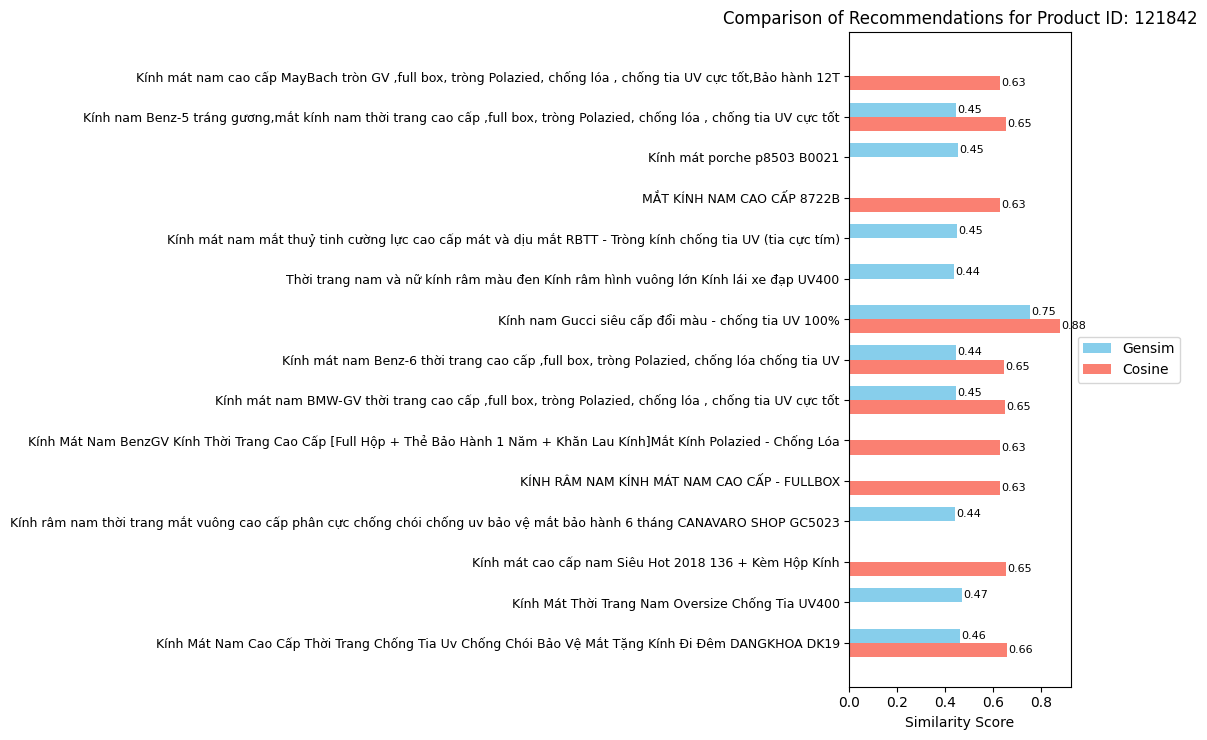

In [ ]:
plot_comparison_bar(product_id_test, sample_df, gensim_sim_matrix, cosine_sim, top_n=10)


In [ ]:
def plot_scatter_cosine_vs_gensim(cosine_sim, gensim_sim, sample_df, sample_size=10000):
    # Flatten matrix để lấy all pair scores
    cosine_flat = cosine_sim.flatten()
    gensim_flat = gensim_sim.flatten()

    # Bỏ self-similarity (điểm so chính mình)
    mask = ~np.eye(sample_df.shape[0], dtype=bool)
    cosine_scores = cosine_flat[mask.flatten()]
    gensim_scores = gensim_flat[mask.flatten()]

    # Sample để plot nhanh hơn
    if sample_size < len(cosine_scores):
        idx = np.random.choice(len(cosine_scores), sample_size, replace=False)
        cosine_scores = cosine_scores[idx]
        gensim_scores = gensim_scores[idx]

    plt.figure(figsize=(8, 6))
    plt.scatter(gensim_scores, cosine_scores, alpha=0.3, s=10, color='teal')
    plt.xlabel('Gensim Similarity')
    plt.ylabel('Cosine Similarity')
    plt.title('Scatter Plot: Gensim vs Cosine Similarity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


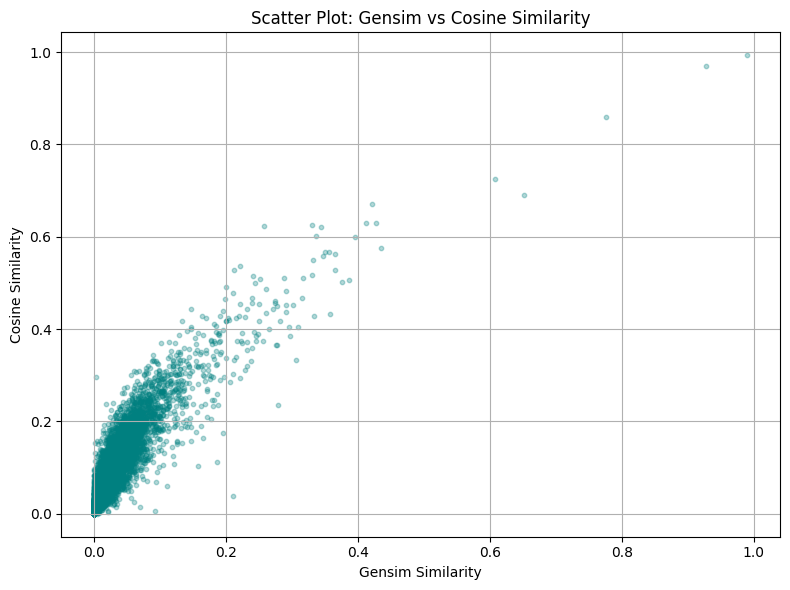

In [ ]:
plot_scatter_cosine_vs_gensim(cosine_sim, gensim_sim_matrix, sample_df)


In [ ]:
# Define ground truth
positive_threshold = 4.0
ground_truth = sample_df[sample_df['rating'] >= positive_threshold]['product_id'].tolist()

# Define evaluation functions
def precision_recall(recommended, ground_truth, k):
    hits = len(set(recommended[:k]) & set(ground_truth))
    precision = hits / k
    recall = hits / len(ground_truth) if ground_truth else 0
    return precision, recall

def calc_f1(precision_list, recall_list):
    f1_list = []
    for p, r in zip(precision_list, recall_list):
        if p + r > 0:
            f1 = 2 * p * r / (p + r)
        else:
            f1 = 0
        f1_list.append(f1)
    return np.mean(f1_list)

# Define list of k values
k_values = [5, 10, 20, 30]

# Prepare results container
results = []

for k in k_values:
    precision_gensim_list = []
    recall_gensim_list = []
    precision_cosine_list = []
    recall_cosine_list = []

    for idx, row in sample_df.iterrows():
        product_id = row['product_id']

        # Gensim recommendations
        rec_gensim = recommend_similar_products_gensim(product_id, sample_df, index, dictionary, tfidf, content_gem_re)
        p_g, r_g = precision_recall(rec_gensim, ground_truth, k)
        precision_gensim_list.append(p_g)
        recall_gensim_list.append(r_g)

        # Cosine recommendations
        rec_cosine = recommend_similar_products_cosine(product_id, sample_df, cosine_sim)
        p_c, r_c = precision_recall(rec_cosine, ground_truth, k)
        precision_cosine_list.append(p_c)
        recall_cosine_list.append(r_c)

    # Calculate F1
    f1_gensim = calc_f1(precision_gensim_list, recall_gensim_list)
    f1_cosine = calc_f1(precision_cosine_list, recall_cosine_list)

    # Append results
    results.append({
        'Model': 'Gensim',
        'k': k,
        'Precision': np.mean(precision_gensim_list),
        'Recall': np.mean(recall_gensim_list),
        'F1-score': f1_gensim
    })
    results.append({
        'Model': 'Cosine',
        'k': k,
        'Precision': np.mean(precision_cosine_list),
        'Recall': np.mean(recall_cosine_list),
        'F1-score': f1_cosine
    })

# Convert to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)


    Model   k  Precision    Recall  F1-score
0  Gensim   5   0.656480  0.000509  0.001017
1  Cosine   5   0.670080  0.000520  0.001038
2  Gensim  10   0.660580  0.001024  0.002045
3  Cosine  10   0.674890  0.001047  0.002090
4  Gensim  20   0.330290  0.001024  0.002042
5  Cosine  20   0.337445  0.001047  0.002087
6  Gensim  30   0.220193  0.001024  0.002039
7  Cosine  30   0.224963  0.001047  0.002083
